Задача оценки стоимости автомобилей
есть тестовая выборка на соревновании
тренировчнуб надо собрать самой с сайта auto.ru

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [ ]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [ ]:
# функия оценки качества модели
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [ ]:
# PATH_to_file_data = '/kaggle/input/all-brands-and-models-for-auto-ru-09-09-2020/'
# df_marks_and_models = pd.read_csv(PATH_to_file_data + 'all_car_brands_and_their_models_from_auto_ru.csv', index_col=0)
# print('Кол-во марок: ', df_marks_and_models.shape[0])
# display(df_marks_and_models.head(2))

# Setup

In [ ]:
VERSION    = 1
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [ ]:
!ls '../input'

In [ ]:
# train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
# test = pd.read_csv(DIR_TEST+'test.csv')
# sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [53]:
# ВРЕМЕННАЯ ИСТОРИЯ ПОКА НЕ СПАРСИЛА ДАННЫЕ :
# тут то, что есть поделила на трейн и тест и буду собирать модель
df = pd.read_csv(DIR_TEST+'test.csv')


Смотрим на сами данные

In [ ]:
class AnalyzNumCol():
    def __init__(self, df, col):
        self.df = df[col]
        self.col = col
        self.col_log = LogDf(df, col).col_log
        self.df_log = LogDf(df, col).df_col_log()
    
    def show_plots(self, size = 5, log = False):
        
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        f = plt.figure()
        f.clear()
        plt.close(f)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (3*size,size))
        
        fig.suptitle('Histogram, QQ-plot and boxplot for {0} '.format(column))
        ax1.hist(data.dropna(), bins = 20, histtype = 'bar', align = 'mid', 
                 rwidth = 0.8, color = 'red')
        fig = sm.qqplot(data.dropna(), fit = True, line ='45', ax=ax2) 
        
        
        
        ax3.boxplot(data.dropna(), vert = False)  # выбросы
     
        plt.show
        
    def emission_limits(self, log = False): # границы выбросов
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        q1 = data.quantile(q = 0.25) 
        q3 = data.quantile(q = 0.75) 
        IQR = q3 - q1
        return q1 - 1.5*IQR, q3 + 1.5*IQR

    def amount_emissions(self, log = False): 
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col

        minb, maxb = self.emission_limits(log)
        return len(data[data < minb])+ len(data[data > maxb])
    
# класс логарифмирования признака
    
class LogDf(): 
    def __init__(self, df, col):
        self.df = df
        self.col = col
        self.col_log = col + '_log'
        
    def df_col_log(self):      

        return  self.df[self.col].apply(lambda x: np.log(x + 1)) 
    
    
    

In [19]:
def has_outliers(column, df):

    q25, q75 = np.percentile(df[column], [25, 75], axis=0)
    iqr = q75-q25
    lower_bound = q25 - 1.5*iqr
    upper_bound = q75 + 1.5*iqr
    
#     print('---------------------------')
#     print('Границы выбросов: ', lower_bound, ', ', upper_bound)
#     print('---------------------------')

    ok_values_cnt = (df[column].loc[df[column].between(
        lower_bound, upper_bound)]).count()
    outliers_cnt = df[column].count() - ok_values_cnt

    print('Количество выбросов', outliers_cnt)
    print('---------------------------')
    
def boxplot_for_numcols(df, col_name, hue_col=None):
    plt.figure()
    # sns.boxplot(x=df[hue_col], y=np.log1p(np.abs(df[col_name])))
    if (hue_col != None):
        sns.boxplot(x=df[hue_col], y=df[col_name])
    else:
        sns.boxplot( y=df[col_name])

    plt.show

    

def lookup_num_col(data, col_name):
    print('Количество пропусков: ', data[col_name].isna().sum())
    plt.figure(figsize=(6,4))
    
    sns.distplot(data[col_name], kde = False, rug=False).set_title(f'Распределение {col_name}')
    
    plt.show()
    sns.distplot(np.log1p(data[col_name]), kde = False, rug=False).set_title(f'Распределение LOG {col_name}')
    plt.show()
    has_outliers(col_name, data)
    boxplot_for_numcols(data, col_name)
    
    
def lookup_cat_col(data, col_name):
    print ('Количество пропусков: ', data[col_name].isna().sum())
    print ('Количество уникальных записей: ', data[col_name].nunique())
    if (data[col_name].nunique()<10):
        display(data[col_namee].value_counts())
    

    
    


In [22]:
df.describe(include = 'object')

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
count,34686,34686,34686,34686,6418,34686,34686,34686,24690,34686,...,34686,34686,34686,34686,11995,34685,34686,34686,34686,34686
unique,24,12,34686,16,2364,31732,55,315,23705,5,...,634,4,2,3,275,2,3,2,1,1
top,седан,BMW,https://auto.ru/cars/used/sale/mercedes/c_klas...,чёрный,"{""id"":""4562904"",""name"":""Elegance"",""available_o...",Выгода до 82 000 руб. при обмене на Ваш автомо...,2.0 LTR,249 N12,"{""leather"":true}",бензин,...,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,EUROPEAN,3 или более,1 год и 10 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен
freq,13147,4473,1,11010,51,264,7391,1708,108,28601,...,2389,19596,20682,15957,209,30098,15565,33287,34686,34686


In [91]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              34686 non-null  object 
 1   brand                 34686 non-null  object 
 2   car_url               34686 non-null  object 
 3   color                 34686 non-null  object 
 4   complectation_dict    6418 non-null   object 
 5   description           34686 non-null  object 
 6   engineDisplacement    34686 non-null  float64
 7   enginePower           34686 non-null  float64
 8   equipment_dict        24690 non-null  object 
 9   fuelType              34686 non-null  object 
 10  image                 34686 non-null  object 
 11  mileage               34686 non-null  int64  
 12  modelDate             34686 non-null  int64  
 13  model_info            34686 non-null  object 
 14  model_name            34686 non-null  object 
 15  name               

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня', 'owners'],
      dtype='object')

In [106]:
df.model_info.nunique()
df.name.isna().sum()
df.name.unique()
display(df[['name', 'enginePower']])

,name,enginePower
0,1.2 AMT (105 л.с.),105.0
1,1.6 MT (110 л.с.),110.0
2,DSG 1.8 AMT (152 л.с.),152.0
3,1.6 AT (110 л.с.),110.0
4,1.8 AT (152 л.с.),152.0
...,...,...
34681,316i 1.6 AT (136 л.с.),136.0
34682,520d xDrive 2.0d AT (190 л.с.) 4WD,190.0
34683,523i 2.5 AT (170 л.с.),170.0
34684,20d 2.0d AT (184 л.с.) 4WD,184.0


In [329]:
df = pd.read_csv(DIR_TEST+'test.csv')

In [330]:
#num
df.enginePower = df.enginePower.str.replace(' N12', '')
df.enginePower = df.enginePower.apply(lambda x: float(x))

df.engineDisplacement = df.engineDisplacement.str.replace(' LTR', '')
df.engineDisplacement = df.engineDisplacement.apply(lambda x: '0' if x=='' else x)
df.engineDisplacement = df.engineDisplacement.apply(lambda x: float(x))

df['delta_prod_modelYears'] = df.productionDate-df.modelDate
df['yearsOld'] = datetime.now().year - df.productionDate


#categories
owners_dict = {'1\xa0владелец': 1, '2\xa0владельца': 2, '3 или более': 3, None : 0}
df['owners'] = df['Владельцы'].replace(to_replace=owners_dict)

custom_house_dict = {'Растаможен':1, 'Не растаможен': 0}
df['Таможня'] = df['Таможня'].replace(to_replace=custom_house_dict)

fuel_type_dict = {'бензин':1, 'дизель':2, 'гибрид':3, 'электро':4, 'газ':5}
df.fuelType = df.fuelType.replace(to_replace=fuel_type_dict)


transmission_dict = {'автоматическая':1, 'механическая':2, 'вариатор':3, 'роботизированная':4} 
df.vehicleTransmission = df.vehicleTransmission.replace(to_replace=transmission_dict)

vendor_dict = {'EUROPEAN':1, 'JAPANESE':2}
df.vendor = df.vendor.replace(to_replace=vendor_dict)

pts_dict = {'Оригинал':1, 'Дубликат':0}
df['ПТС'] = df['ПТС'].replace(to_replace=pts_dict)

wheeldrive_dict = {'передний':1, 'полный':2, 'задний':3}
df['Привод'] = df['Привод'].replace(to_replace=wheeldrive_dict)

st_wheel_dict = {'Левый':1, 'Правый':0}
df['Руль'] = df['Руль'].replace(to_replace=st_wheel_dict)

df.bodyType = df.bodyType.apply(lambda x : 'cедан' if x=='седан 2 дв.' else x)
df.bodyType = df.bodyType.apply(lambda x : 'хэтчбек' if x=='хэтчбек 3 дв.' else x)
df.bodyType = df.bodyType.apply(lambda x : 'хэтчбек' if x=='хэтчбек 5 дв.' else x)
df.bodyType = df.bodyType.apply(lambda x : 'внедорожник' if x=='внедорожник 5 дв.' else x)
df.bodyType = df.bodyType.apply(lambda x : 'внедорожник' if x=='внедорожник 3 дв.' else x)







#dates
df['parsing_date'] = df.parsing_unixtime.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))



In [331]:
df.bodyType.value_counts()

седан                      13147
внедорожник 5 дв.          12228
хэтчбек                     2609
лифтбек                     2232
универсал 5 дв.             1276
минивэн                      995
купе                         824
компактвэн                   489
пикап двойная кабина         280
купе-хардтоп                 158
внедорожник 3 дв.            115
родстер                       99
фургон                        97
кабриолет                     90
седан-хардтоп                 12
микровэн                       7
лимузин                        6
cедан                          6
пикап одинарная кабина         5
пикап полуторная кабина        5
внедорожник открытый           3
тарга                          2
фастбек                        1
Name: bodyType, dtype: int64

In [319]:
df[(df.bodyType=='хэтчбек 5 дв.') | (df.bodyType=='хэтчбек 3 дв.')][['bodyType', 'numberOfDoors']]
df[(df.bodyType=='хэтчбек 5 дв.') | (df.bodyType=='хэтчбек 3 дв.')][['bodyType', 'numberOfDoors']]


#df.color.isna().sum()

,bodyType,numberOfDoors
29,хэтчбек 5 дв.,5
32,хэтчбек 5 дв.,5
60,хэтчбек 5 дв.,5
63,хэтчбек 5 дв.,5
70,хэтчбек 5 дв.,5
...,...,...
34586,хэтчбек 5 дв.,5
34613,хэтчбек 5 дв.,5
34623,хэтчбек 5 дв.,5
34672,хэтчбек 5 дв.,5


In [304]:
num_cols = ['engineDisplacement', 'enginePower', 'numberOfDoors', 'delta_prod_modelDate', 'yearsOld' ]

cat_cols = ['brand', 'color', 'fuelType', 'owners', 'vehicleTransmission','ПТС', 'Привод' , 'Руль', 'Состояние','Таможня', 'vendor']

to_del = ['car_url', 'complectation_dict', 'description', 'equipment_dict', 'image', 'model_info', 'model_name', 'name', 'priceCurrency', 'vehicleConfiguration', 'Состояние' ]

In [309]:
df.drop(columns=to_del, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bodyType               34686 non-null  object 
 1   brand                  34686 non-null  object 
 2   color                  34686 non-null  object 
 3   engineDisplacement     34686 non-null  float64
 4   enginePower            34686 non-null  float64
 5   fuelType               34686 non-null  int64  
 6   mileage                34686 non-null  int64  
 7   modelDate              34686 non-null  int64  
 8   numberOfDoors          34686 non-null  int64  
 9   parsing_unixtime       34686 non-null  int64  
 10  productionDate         34686 non-null  int64  
 11  sell_id                34686 non-null  int64  
 12  super_gen              34686 non-null  object 
 13  vehicleTransmission    34686 non-null  int64  
 14  vendor                 34686 non-null  int64  
 15  Вл

Количество пропусков:  0


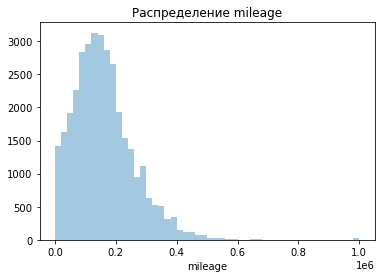

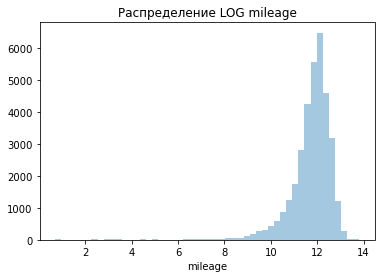

Количество выбросов 692
---------------------------


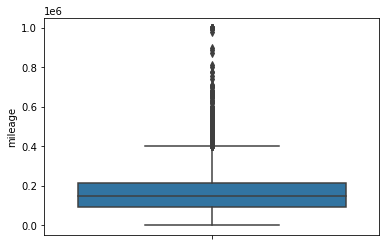

In [256]:
lookup_num_col(df, 'mileage')

## Data Preprocessing

In [257]:
import pandas as pd
import requests, json
import time
import os

import os

pd.options.mode.chained_assignment = None

# этот блок закомментирован так как используется только на kaggle
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
PATH_to_file = '/kaggle/input/sf-dst-car-price/'
PATH_to_file_data = '/kaggle/input/all-brands-and-models-for-auto-ru-09-09-2020/'

# # этот блок закомментирован так как используется только локальной машине
# from importlib import reload
# print(os.listdir('./data'))
# PATH_to_file = './data/'


/kaggle/input/parsing-all-moscow-auto-ru-09-09-2020/all_auto_ru_09_09_2020.csv
/kaggle/input/sf-dst-car-price-prediction/sample_submission.csv
/kaggle/input/sf-dst-car-price-prediction/test.csv


In [ ]:
# dict_of_num_cars_of_models ={'AC':2, 'Acura':94, 'Alfa Romeo':65, 'Alpina':10, 
#                              'AMC':2, 'Ariel':1, 'Asia':1, 'Aston Martin':25, 
#                              'Audi':4093, 'Austin Healey':1, 'Bajaj':3, 
#                              'Bentley':104, 'BMW':7423, 'Borgward':1, 
#                              'Brilliance':10, 'Buick':17, 'BYD':22, 
#                              'Cadillac':321, 'Changan':100, 'Chery':593, 
#                              'Chevrolet':3670, 'Chrysler':316, 'Citroen':1142, 
#                              'Dacia':9, 'Daewoo':1024, 'Daihatsu':47, 
#                              'Daimler':5, 'Datsun':212, 'Delage':1, 'Derways':2, 
#                              'DKW':1, 'Dodge':413, 'DongFeng':25, 'Doninvest':2, 
#                              'DS':3, 'DW Hower':8, 'Eagle':1, 'Excalibur':1, 
#                              'FAW':66, 'Ferrari':29, 'Fiat':206, 'Ford':4812, 
#                              'Foton':2, 'GAC':14, 'Geely':302, 'Genesis':54, 
#                              'GMC':26, 'Great Wall':420, 'Hafei':6, 'Haima':12, 
#                              'Haval':110, 'Hawtai':4, 'Heinkel':1, 'Honda':1179, 
#                              'HuangHai':1, 'Hummer':70, 'Hyundai':5712, 
#                              'Infiniti':1041, 'Innocenti':1, 'Iran Khodro':21, 
#                              'Isuzu':43, 'JAC':8, 'Jaguar':308, 'Jeep':466, 'JMC':1, 
#                              'Kia':5595, 'LADA (ВАЗ)':8935, 'Lamborghini':14, 
#                              'Lancia':8, 'Land Rover':1616, 'Lexus':985, 
#                              'Lifan':295, 'Lincoln':62, 'Lotus':1, 'Luxgen':9, 
#                              'Mahindra':1, 'Maserati':54, 'Maybach':7, 
#                              'Mazda':2311, 'McLaren':5, 'Mercedes-Benz':8005, 
#                              'Mercury':16, 'Metrocab':2, 'MG':10, 'MINI':313, 
#                              'Mitsubishi':3935, 'Mitsuoka':3, 'Nissan':5776, 
#                              'Oldsmobile':10, 'Opel':3131, 'Packard':2, 
#                              'Peugeot':1636, 'Plymouth':13, 'Pontiac':38, 
#                              'Porsche':714, 'Proton':3, 'PUCH':1, 'Ravon':112, 
#                              'Renault':2771, 'Rolls-Royce':55, 'Rover':69, 
#                              'Saab':147, 'Saturn':9, 'Scion':9, 'SEAT':77, 
#                              'Shanghai Maple':1, 'Skoda':2810, 'Smart':89, 
#                              'SsangYong':718, 'Subaru':934, 'Suzuki':878, 
#                              'Tatra':5, 'Tesla':43, 'Tianma':2, 'Toyota':4648, 
#                              'Triumph':1, 'Vauxhall':1, 'Volkswagen':7109, 
#                              'Volvo':2069, 'Vortex':91, 'Wartburg':1, 'Willys':2, 
#                              'Zotye':15, 'ZX':4, 'ГАЗ':935, 'Гоночный болид':2, 
#                              'ЗАЗ':231, 'ЗИЛ':2, 'ИЖ':129, 'ЛуАЗ':45, 
#                              'Москвич':198, 'СМЗ':4, 'ТагАЗ':68, 'УАЗ':1107}

# # уберем модели с кол-вом объявлений ниже 300 и повысим регистр индексов 
# list_keys_to_delete = []
# for mark in dict_of_num_cars_of_models.keys():
#     if dict_of_num_cars_of_models[mark] < 300:
#         list_keys_to_delete.append(mark)
    
# for key in list_keys_to_delete: del dict_of_num_cars_of_models[key]

# for mark in list(dict_of_num_cars_of_models.keys()):
#     mark_up = mark.upper()
#     dict_of_num_cars_of_models[mark_up]=dict_of_num_cars_of_models.pop(mark)
    
# print(f'всего марок с кол-вом объявлений более 300 := {len(dict_of_num_cars_of_models)}')


# # посмотрим на список получившихся моделей
# print(*dict_of_num_cars_of_models, sep=',')

# # Удалим отечественные модели
# for key in ['LADA (ВАЗ)','ГАЗ','УАЗ']: 
#     del dict_of_num_cars_of_models[key]
    
# list_of_relevant_marks = list(dict_of_num_cars_of_models.keys())

# sum_of_ads = sum(dict_of_num_cars_of_models.values())
# print(f"примерное кол-во строк после парсинга должно быть := {sum_of_ads}")


# # оригинал с кагля

# HEADERS = {
#     'Accept': '*/*',
#     'Accept-Encoding': 'gzip, deflate, br',
#     'Accept-Language': 'ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3',
#     'Connection': 'keep-alive',
#     'Content-Length': '137',
#     'content-type': 'application/json',
#     'Cookie': '_csrf_token=1c0ed592ec162073ac34d79ce511f0e50d195f763abd8c24; autoru_sid=a%3Ag5e3b198b299o5jhpv6nlk0ro4daqbpf.fa3630dbc880ea80147c661111fb3270%7C1580931467355.604800.8HnYnADZ6dSuzP1gctE0Fw.cd59AHgDSjoJxSYHCHfDUoj-f2orbR5pKj6U0ddu1G4; autoruuid=g5e3b198b299o5jhpv6nlk0ro4daqbpf.fa3630dbc880ea80147c661111fb3270; suid=48a075680eac323f3f9ad5304157467a.bc50c5bde34519f174ccdba0bd791787; from_lifetime=1580933172327; from=yandex; X-Vertis-DC=myt; crookie=bp+bI7U7P7sm6q0mpUwAgWZrbzx3jePMKp8OPHqMwu9FdPseXCTs3bUqyAjp1fRRTDJ9Z5RZEdQLKToDLIpc7dWxb90=; cmtchd=MTU4MDkzMTQ3MjU0NQ==; yandexuid=1758388111580931457; bltsr=1; ',
#     'Host': 'auto.ru',
#     'origin': 'https://auto.ru/cars/all/',
#     'Referer': 'https://auto.ru/cars/all/',
#     'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:72.0) Gecko/20100101 Firefox/72.0',
#     'x-client-app-version': '202002.03.092255',
#     'x-client-date': '1580933207763',
#     'x-csrf-token': '1c0ed592ec162073ac34d79ce511f0e50d195f763abd8c24',
#     'x-page-request-id': '60142cd4f0c0edf51f96fd0134c6f02a',
#     'x-requested-with': 'fetch'
# }

In [ ]:
train.dropna(subset=['productionDate','mileage'], inplace=True)
train.dropna(subset=['price'], inplace=True)

In [ ]:
# для baseline просто возьму пару схожих признаков без полной обработки
columns = ['bodyType', 'brand', 'productionDate', 'engineDisplacement', 'mileage']
df_train = train[columns]
df_test = test[columns]

In [ ]:
y = train['price']

## Label Encoding

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [ ]:
for colum in ['bodyType', 'brand', 'engineDisplacement']:
    data[colum] = data[colum].astype('category').cat.codes

In [ ]:
data

In [ ]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

## Train Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [ ]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [ ]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

# # Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [ ]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [ ]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Вот так просто со старта, даже не трогая сами данные и не подбирая настройки catboosta, получаем модель с уровнем ошибки в 18%!

### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [ ]:
np.log(y_train)

In [ ]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

In [ ]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [ ]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Как видим точность возросла до 15%, а что будет на ЛБ?

# Submission

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

В итоге получили **MAPE 27%** на ЛБ!

Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing